
# Stochastic Simulations Assignment 3: 
## Reverse Engineering Predator-Prey System

----
### Margarita Petrova 15794717
### Kushnava Singha 15663388
### Zainab Nasser 15097331
--- 

This notebook is used for ease to answer to the questions from the assignment. The specific functions can be found in the respective Python files. Let's start!

In [21]:
from src import *
plt.rcParams['figure.dpi'] = 150

In [2]:
from scipy.integrate import solve_ivp, odeint
import numpy as np
from scipy.optimize import minimize, dual_annealing
import pandas as pd 
import matplotlib.pyplot as plt

### Plotting the data provided to us

Optimization Functions - Global and Local 
--- 
We are setting starting parameters($\alpha$ = 1.7, $\beta$ = 0.8, $\gamma$ =1.4 , $\delta$ = 0.6) in order to solve the Lotka Volterra equations by using odeint.

C:\Users\magggien\AppData\Local\Temp\ipykernel_21160\870594986.py:24: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, init_cond, t_obs, args=(alpha, beta, gamma, delta))


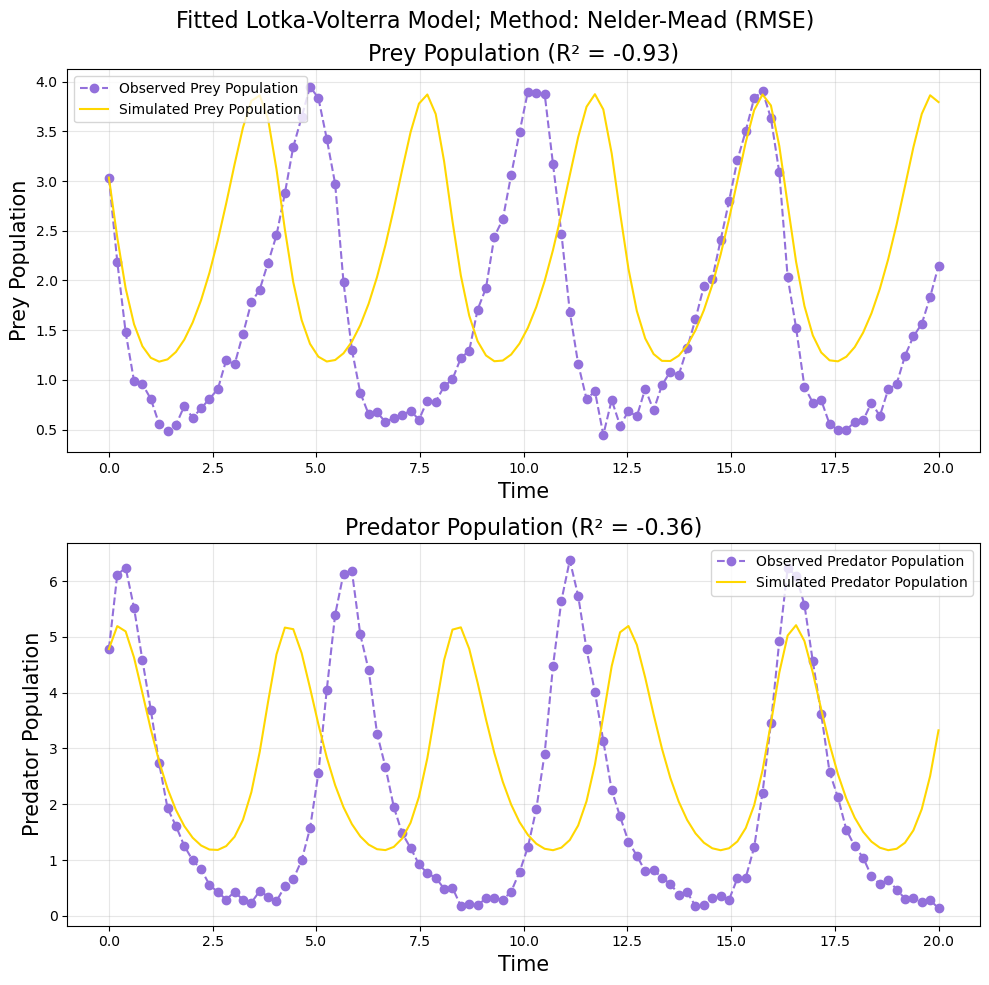

[1.28259009 0.47285917 1.99999188 0.8815759 ]


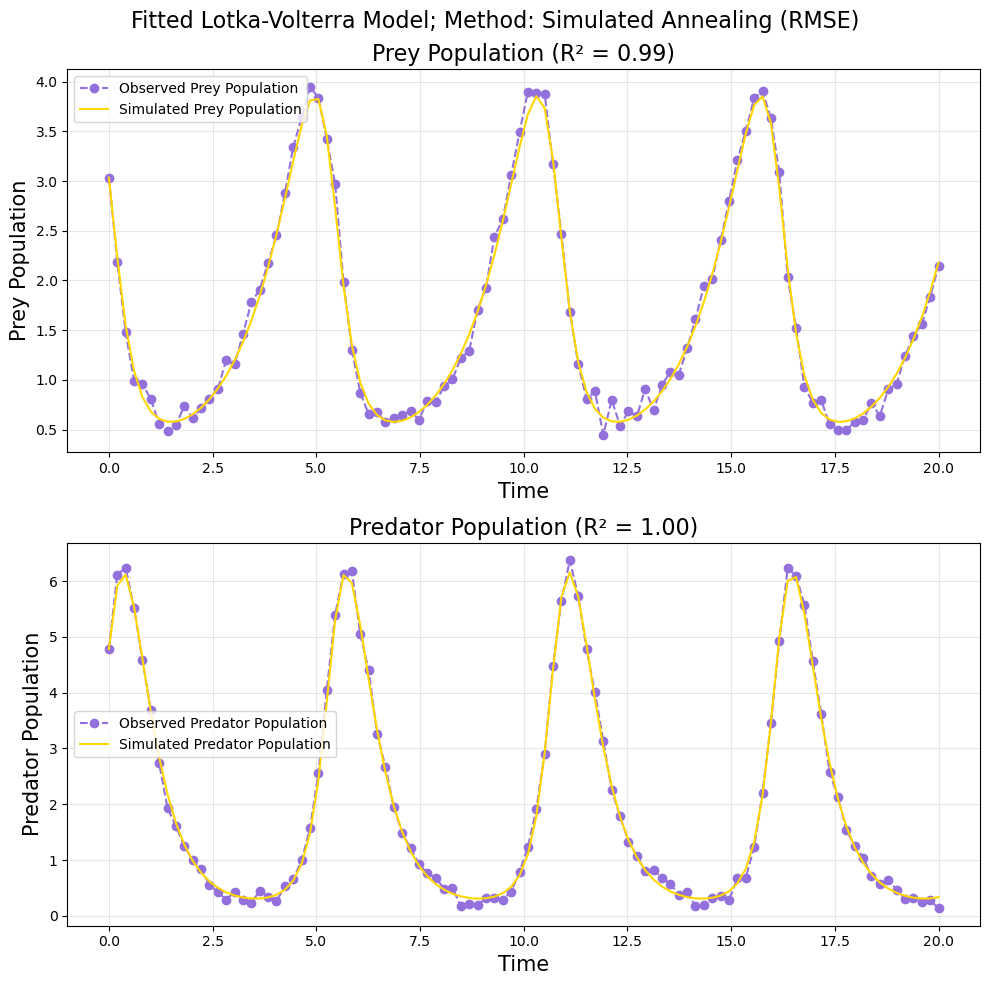

[0.85987229 0.4396975  2.         1.15808849]


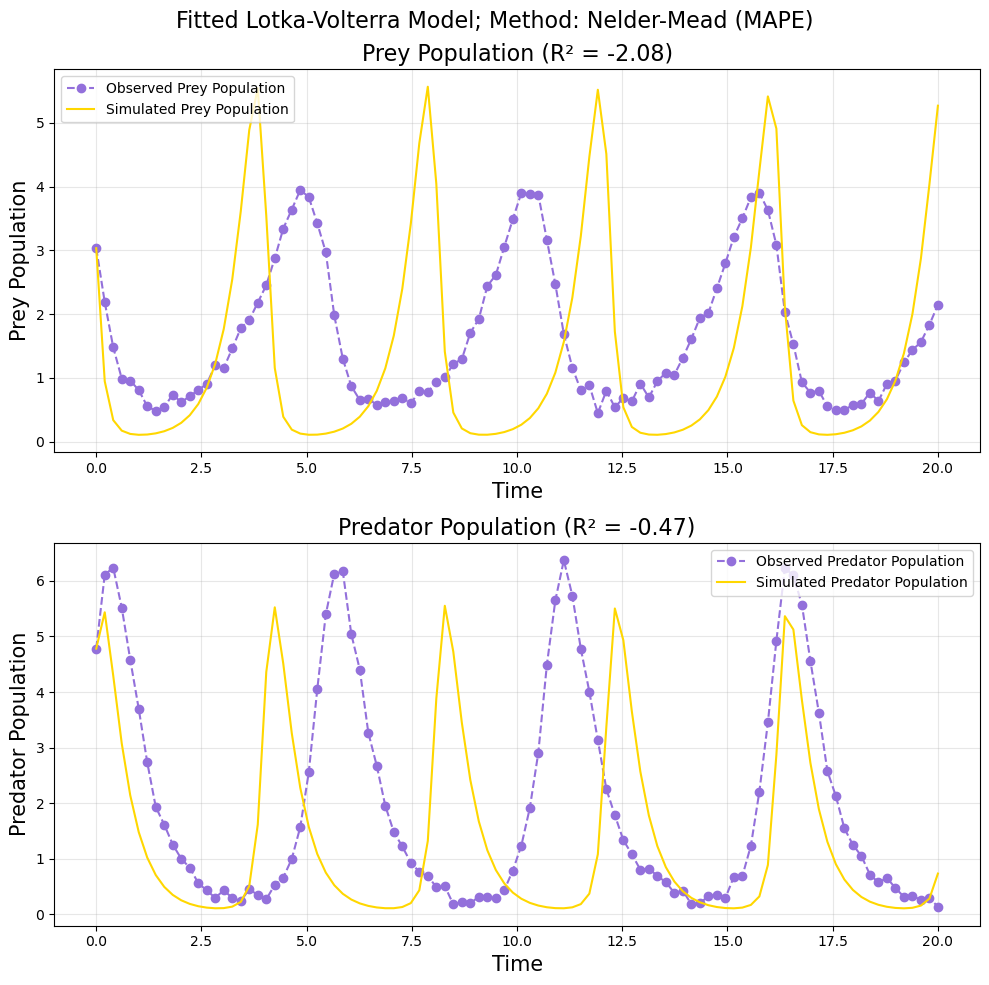

[1.97669259 1.44210651 1.99924595 1.44566363]


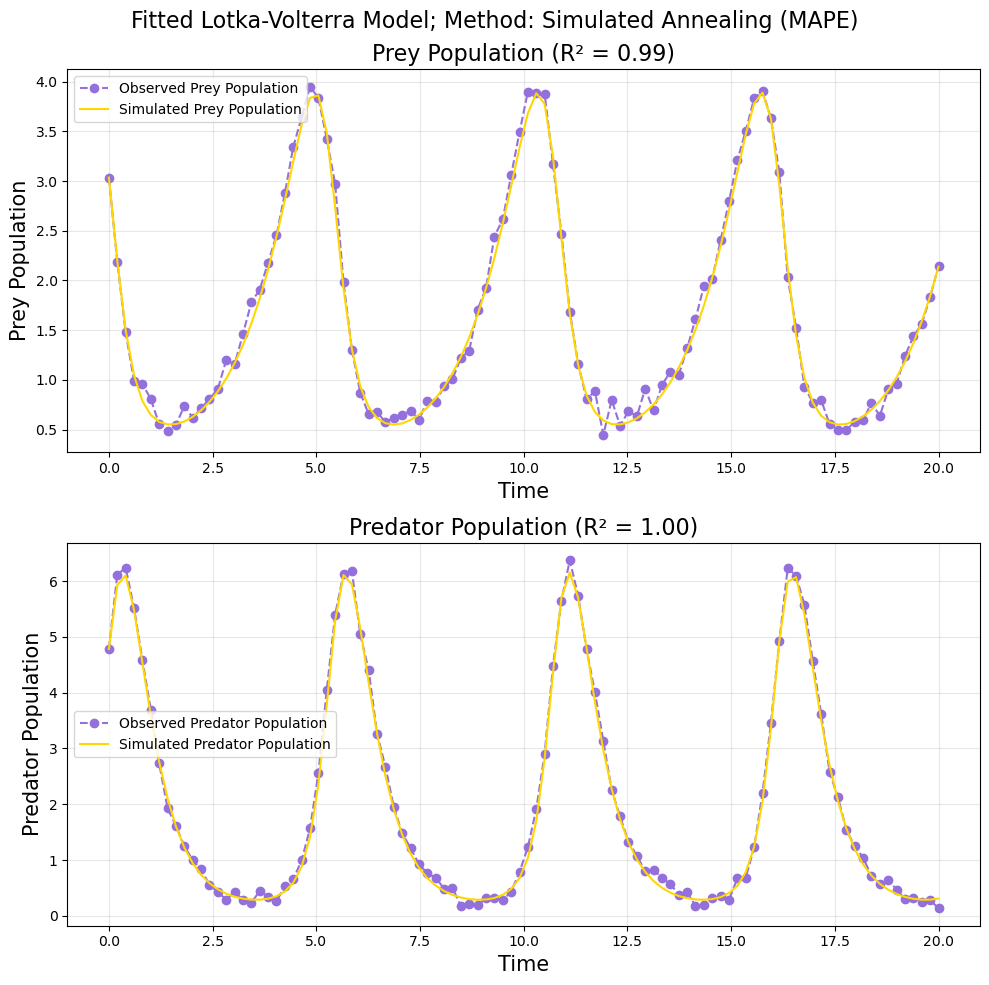

[0.87013646 0.45384319 1.99458747 1.16775386]


In [6]:
t_obs, x_obs, y_obs = load_data(r"C:\Users\magggien\Documents\Masters\LotkaVolterra-ModelFitting\data\predator-prey-data.csv")

init_cond = [x_obs[0], y_obs[0]]

#init_guess = (1.0, 0.5, 1.5, 1.0) #This guess was found using global optimization methtod to improve Nelder-Mead method. 
init_guess = (1.7, 0.8, 1.4, 0.6) # This is a 'best initial guess' using previous biology/predator-prey knowledge.
bounds = [(0, 2), (0, 2), (0, 2), (0, 2)]

optimized_params_local_RMSE = local_optimization_RMSE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_RMSE = global_optimization_RMSE(bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_local_MAPE = local_optimization_MAPE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_MAPE = global_optimization_MAPE(bounds, t_obs, init_cond, x_obs, y_obs)

sim_data_local_RMSE = simulate_model(optimized_params_local_RMSE, init_cond, t_obs)
sim_data_global_RMSE = simulate_model(optimized_params_global_RMSE, init_cond, t_obs)
sim_data_local_MAPE = simulate_model(optimized_params_local_MAPE, init_cond, t_obs)
sim_data_global_MAPE = simulate_model(optimized_params_global_MAPE, init_cond, t_obs)

method = "Nelder-Mead (RMSE)"
plot_diffs(method, t_obs, x_obs, y_obs, sim_data_local_RMSE[0], sim_data_local_RMSE[1])
print(optimized_params_local_RMSE)
method = "Simulated Annealing (RMSE)"
plot_diffs(method, t_obs, x_obs, y_obs, sim_data_global_RMSE[0], sim_data_global_RMSE[1])
print(optimized_params_global_RMSE)
method = "Nelder-Mead (MAPE)"
plot_diffs(method, t_obs, x_obs, y_obs, sim_data_local_MAPE[0], sim_data_local_MAPE[1])
print(optimized_params_local_MAPE)
method = "Simulated Annealing (MAPE)"
plot_diffs(method, t_obs, x_obs, y_obs, sim_data_global_MAPE[0], sim_data_global_MAPE[1])
print(optimized_params_global_MAPE) 


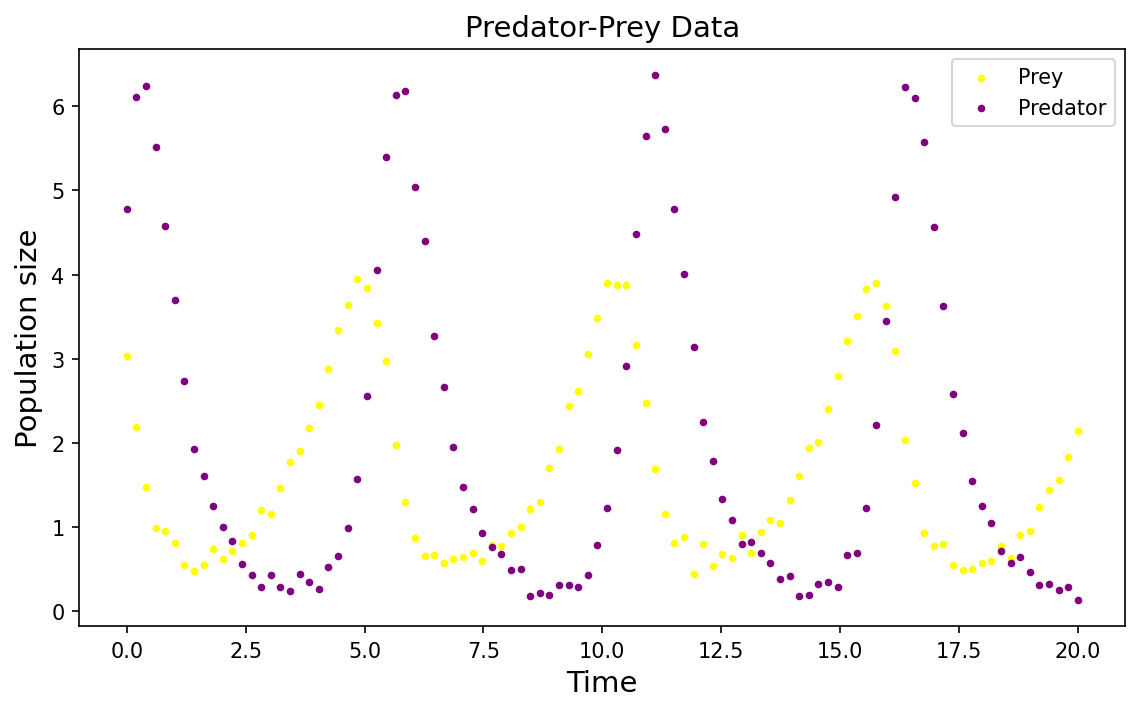

In [78]:
plt.figure(figsize=(9, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_obs, x_obs, color='yellow', s=7, label='Prey')
plt.scatter(t_obs, y_obs, color='purple', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

In [7]:
# Print all initial settings
print("Initial conditions:")
print(f"init_guess = {init_guess}")
print(f"bounds = {bounds}")
print(f"init_cond = {init_cond}")

# Print shapes of input data
print("\nData shapes:")
print(f"t_obs shape: {t_obs.shape}")
print(f"x_obs shape: {x_obs.shape}")
print(f"y_obs shape: {y_obs.shape}")

# Print first few values of data
print("\nFirst few values:")
print(f"t_obs[:5] = {t_obs[:5]}")
print(f"x_obs[:5] = {x_obs[:5]}")
print(f"y_obs[:5] = {y_obs[:5]}")

Initial conditions:
init_guess = (1.7, 0.8, 1.4, 0.6)
bounds = [(0, 2), (0, 2), (0, 2), (0, 2)]
init_cond = [3.0352573560247955, 4.781635091554791]

Data shapes:
t_obs shape: (100,)
x_obs shape: (100,)
y_obs shape: (100,)

First few values:
t_obs[:5] = [0.         0.2020202  0.4040404  0.60606061 0.80808081]
x_obs[:5] = [3.03525736 2.18974589 1.47890677 0.98983604 0.95782741]
y_obs[:5] = [4.78163509 6.11400461 6.23836095 5.52052405 4.58254575]


In [8]:
# Get baseline parameters from global RMSE optimization
baseline_params = optimized_params_global_RMSE

# Run multiple trials to get confidence intervals
n_trials = 10
baseline_trials = []

for seed in range(n_trials):
    result = global_optimization_RMSE(bounds, t_obs, init_cond, x_obs, y_obs)
    baseline_trials.append(result)

baseline_trials = np.array(baseline_trials)
baseline_conf = np.std(baseline_trials, axis=0, ddof=1) / np.sqrt(n_trials)


## Experiments

Let's answer the following questions: 

How many data-points from each time-series you could remove until you are not
able to reverse-engineer the parameters any more?
* First, let's try to find the importance of each time-series on reverse-engineering
process by fixing one time-series and removing data-points from the other
one. In this way, you will find the critical number of data-points for each
time-series.



Starting predator deletion analysis at 16:02:29

Scenario 1/8: Removing 20 points...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   38.9s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   39.2s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   40.1s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 20 points removed:
Parameter values across trials:
α values: [0.97499141 0.86163371 0.86163413 0.86163353 0.8616342  0.86163182
 0.86163449 0.8616338  0.86163401 0.86163184]
β values: [0.48763162 0.44036178 0.4403619  0.44036167 0.44036187 0.44036087
 0.44036213 0.4403625  0.44036193 0.44036077]
γ values: [1.76857101 1.99587546 1.99587426 1.99587603 1.99587501 1.99587938
 1.99587365 1.99587694 1.99587485 1.99587897]
δ values: [1.07343705 1.15569893 1.15569828 1.15569938 1.15569976 1.15570043
 1.1556982  1.15570105 1.1556988  1.15569943]

Optimized parameters:
- α: 0.8730 ± 0.0256
- β: 0.4451 ± 0.0107
- γ: 1.9731 ± 0.0514
- δ: 1.1475 ± 0.0186

Scenario 2/8: Removing 40 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.6s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.5s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 40 points removed:
Parameter values across trials:
α values: [0.8694269  0.85932313 0.85932318 0.85932252 0.86752519 0.85932314
 0.85932347 0.85932349 0.85932318 0.8593231 ]
β values: [0.44353508 0.4392007  0.43920071 0.43920015 0.44264927 0.43920071
 0.43920278 0.43920101 0.43920038 0.43920068]
γ values: [1.97405711 2.         2.         2.         1.98027025 2.
 2.         2.         2.         2.        ]
δ values: [1.14186813 1.1565135  1.15651367 1.15651193 1.1472805  1.15651354
 1.1565112  1.15651401 1.15651411 1.15651346]

Optimized parameters:
- α: 0.8612 ± 0.0028
- β: 0.4400 ± 0.0012
- γ: 1.9954 ± 0.0070
- δ: 1.1541 ± 0.0037

Scenario 3/8: Removing 60 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   30.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   30.9s remaining:   30.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.5s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 60 points removed:
Parameter values across trials:
α values: [0.85650218 0.85650122 0.8565027  0.85650188 0.85650214 0.85650105
 0.87643305 0.85650176 0.85650143 0.85650191]
β values: [0.43887838 0.43887691 0.43887923 0.43887753 0.43887777 0.43887671
 0.44852524 0.43887712 0.43887699 0.4388776 ]
γ values: [2.         2.         2.         2.         2.         2.
 1.95877957 2.         2.         2.        ]
δ values: [1.14839838 1.14839654 1.14839862 1.14839809 1.14839879 1.14839619
 1.13591092 1.1483983  1.14839722 1.14839812]

Optimized parameters:
- α: 0.8585 ± 0.0045
- β: 0.4398 ± 0.0022
- γ: 1.9959 ± 0.0093
- δ: 1.1471 ± 0.0028

Scenario 4/8: Removing 80 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   30.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.1s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.3s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 80 points removed:
Parameter values across trials:
α values: [0.89535033 0.89535934 0.89510438 0.89536968 0.89535358 0.89552255
 0.89525823 0.89472746 0.8953297  0.89513705]
β values: [0.46123948 0.46123667 0.46113351 0.46126865 0.46123633 0.4613275
 0.46121244 0.46100643 0.46123812 0.46115415]
γ values: [1.91627727 1.9162905  1.91682053 1.9163204  1.91627689 1.91594183
 1.91652581 1.91754373 1.91631159 1.91676018]
δ values: [1.10793073 1.10799652 1.10819682 1.10803265 1.10795576 1.10782058
 1.1080912  1.10836353 1.10793489 1.10817558]

Optimized parameters:
- α: 0.8953 ± 0.0002
- β: 0.4612 ± 0.0001
- γ: 1.9165 ± 0.0003
- δ: 1.1080 ± 0.0001

Scenario 5/8: Removing 85 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   30.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   30.3s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   30.3s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 85 points removed:
Parameter values across trials:
α values: [0.85642075 0.85642065 0.8564206  0.85642031 0.8564205  0.86545909
 0.85642059 0.85642023 0.8564207  0.85641887]
β values: [0.440162   0.44016196 0.44016186 0.44016142 0.44016172 0.44723118
 0.44016184 0.44016138 0.44016217 0.44015956]
γ values: [2.         2.         2.         2.         2.         1.99296404
 2.         2.         2.         2.        ]
δ values: [1.14693452 1.14693411 1.14693427 1.14693376 1.14693421 1.15947846
 1.14693425 1.14693348 1.14693379 1.14693086]

Optimized parameters:
- α: 0.8573 ± 0.0020
- β: 0.4409 ± 0.0016
- γ: 1.9993 ± 0.0016
- δ: 1.1482 ± 0.0028

Scenario 6/8: Removing 88 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.3s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.9s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 88 points removed:
Parameter values across trials:
α values: [0.85480317 0.85480378 0.85480356 0.85480402 0.8548036  0.85480565
 0.85480422 0.85480367 0.85169669 0.85480401]
β values: [0.43706003 0.4370607  0.43706047 0.43706085 0.43706051 0.4370624
 0.43706147 0.43706064 0.43447114 0.43706035]
γ values: [2.         2.         2.         2.         2.         2.
 2.         2.         1.99973332 2.        ]
δ values: [1.1419893  1.14199051 1.14199004 1.1419905  1.14199013 1.14199487
 1.14199082 1.1419902  1.13387201 1.14199205]

Optimized parameters:
- α: 0.8545 ± 0.0007
- β: 0.4368 ± 0.0006
- γ: 2.0000 ± 0.0001
- δ: 1.1412 ± 0.0018

Scenario 7/8: Removing 90 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   30.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.1s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 90 points removed:
Parameter values across trials:
α values: [0.90749045 0.90749043 0.90749868 0.90751461 0.91826859 0.90749041
 0.90749265 0.90749351 0.90749979 0.90748759]
β values: [0.46377288 0.46377287 0.46377692 0.46377458 0.46990538 0.46377247
 0.4637738  0.46377368 0.46377771 0.46377067]
γ values: [1.9038462  1.90384676 1.90383043 1.90378814 1.88299414 1.90384534
 1.90384141 1.90383972 1.90382814 1.90385201]
δ values: [1.12408426 1.12408522 1.12407914 1.12405994 1.11474992 1.12408323
 1.12408216 1.12408208 1.12407743 1.12408809]

Optimized parameters:
- α: 0.9086 ± 0.0024
- β: 0.4644 ± 0.0014
- γ: 1.9018 ± 0.0047
- δ: 1.1231 ± 0.0021

Scenario 8/8: Removing 95 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   21.4s remaining:   50.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   21.8s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 95 points removed:
Parameter values across trials:
α values: [0.88758152 0.88756604 0.88756408 0.88755582 0.88754842 0.88758169
 0.88756405 0.88753063 0.88759365 0.887579  ]
β values: [0.45230196 0.45229281 0.45229035 0.45228705 0.45228802 0.45229998
 0.45229008 0.45227359 0.45231102 0.45229863]
γ values: [1.92793627 1.92795168 1.92796698 1.92798765 1.92800376 1.92791946
 1.92796824 1.92805638 1.92791194 1.92793849]
δ values: [1.11014392 1.11012878 1.11015256 1.11016501 1.1101677  1.11011719
 1.11015389 1.11020876 1.11013202 1.11014136]

Optimized parameters:
- α: 0.8876 ± 0.0000
- β: 0.4523 ± 0.0000
- γ: 1.9280 ± 0.0000
- δ: 1.1102 ± 0.0000

Analysis complete for predator deletion!

Results Summary:
 points_removed  alpha_mean  alpha_conf  beta_mean  beta_conf  gamma_mean  gamma_conf  delta_mean  delta_conf
           20.0    0.872969    0.025643   0.445089   0.010693    1.973146    0.051420    1.147473    0.018609
           40.0    0.861154    0.002779   0.439979 

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.4s remaining:   32.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.7s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 20 points removed:
Parameter values across trials:
α values: [0.86435872 0.86436038 0.86435614 0.8643543  0.86435487 0.86435085
 0.86435673 0.86435589 0.86435642 0.8644221 ]
β values: [0.4433763  0.44337746 0.44337577 0.44337422 0.44337145 0.44337164
 0.4433759  0.44337537 0.44337555 0.44341634]
γ values: [1.99270672 1.99270386 1.99271472 1.99271642 1.99271178 1.99272016
 1.99271269 1.99271398 1.99271248 1.99257961]
δ values: [1.1559244  1.15592346 1.15592973 1.15592828 1.15592634 1.15592391
 1.15592896 1.15592813 1.15592726 1.15587762]

Optimized parameters:
- α: 0.8644 ± 0.0000
- β: 0.4434 ± 0.0000
- γ: 1.9927 ± 0.0000
- δ: 1.1559 ± 0.0000

Scenario 2/8: Removing 40 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   32.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.4s remaining:   32.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.9s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 40 points removed:
Parameter values across trials:
α values: [0.86486768 0.86486877 0.86486714 0.86487153 0.86486783 0.86486758
 0.8648682  0.8648681  0.86487293 0.86486781]
β values: [0.44451003 0.44451004 0.44450979 0.44451262 0.4445097  0.44450989
 0.44451014 0.44451021 0.44451237 0.44451017]
γ values: [1.9918045  1.99180187 1.99180579 1.99179826 1.99180103 1.99180445
 1.9918029  1.99180342 1.99179252 1.9918044 ]
δ values: [1.15414203 1.1541416  1.15414264 1.15414148 1.15413634 1.15414185
 1.1541411  1.1541414  1.15413722 1.15414215]

Optimized parameters:
- α: 0.8649 ± 0.0000
- β: 0.4445 ± 0.0000
- γ: 1.9918 ± 0.0000
- δ: 1.1541 ± 0.0000

Scenario 3/8: Removing 60 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.2s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 60 points removed:
Parameter values across trials:
α values: [0.85669997 0.85669857 0.85670057 0.8567038  0.8567012  0.85669979
 0.85670138 0.85669948 0.85670033 0.85669912]
β values: [0.43296349 0.4329623  0.4329643  0.43295593 0.43296497 0.43296371
 0.43296741 0.43296339 0.43296422 0.43296598]
γ values: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
δ values: [1.15742279 1.15741927 1.15742386 1.15744843 1.15742527 1.15742173
 1.15742212 1.15742126 1.15742307 1.15741585]

Optimized parameters:
- α: 0.8567 ± 0.0000
- β: 0.4330 ± 0.0000
- γ: 2.0000 ± 0.0000
- δ: 1.1574 ± 0.0000

Scenario 4/8: Removing 80 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.9s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 80 points removed:
Parameter values across trials:
α values: [0.86778999 0.867789   0.86779078 0.86777262 0.86778658 0.86779159
 0.86778952 0.86778462 0.86778997 0.86779086]
β values: [0.44661883 0.44661874 0.44661734 0.44661364 0.44661449 0.44662024
 0.44661895 0.4466177  0.44661926 0.44661968]
γ values: [1.99291275 1.99291542 1.99291108 1.99295741 1.99291523 1.99291024
 1.99291423 1.99292604 1.9929136  1.99291185]
δ values: [1.1704541  1.17045584 1.17045574 1.17047043 1.17045268 1.17045428
 1.17045541 1.17046056 1.17045583 1.17045482]

Optimized parameters:
- α: 0.8678 ± 0.0000
- β: 0.4466 ± 0.0000
- γ: 1.9929 ± 0.0000
- δ: 1.1705 ± 0.0000

Scenario 5/8: Removing 85 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.4s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 85 points removed:
Parameter values across trials:
α values: [0.89700085 0.89687309 0.8969049  0.89688872 0.89689082 0.89689383
 0.89688915 0.89688347 0.89688902 0.89686625]
β values: [0.4715049  0.47142152 0.47142931 0.47143384 0.47142753 0.47143025
 0.47142829 0.47142556 0.47142664 0.47141479]
γ values: [1.9293598  1.92961819 1.92956308 1.92958692 1.92956986 1.92956549
 1.92957703 1.92959132 1.92957309 1.92962476]
δ values: [1.11760712 1.11773444 1.11774195 1.11771932 1.11770179 1.11770051
 1.11770743 1.11771703 1.11770248 1.11773403]

Optimized parameters:
- α: 0.8969 ± 0.0000
- β: 0.4714 ± 0.0000
- γ: 1.9296 ± 0.0001
- δ: 1.1177 ± 0.0000

Scenario 6/8: Removing 88 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   32.2s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 88 points removed:
Parameter values across trials:
α values: [0.86533369 0.86533123 0.86533045 0.86533339 0.8653324  0.86533384
 0.86533306 0.86533347 0.86533199 0.86533334]
β values: [0.44209738 0.44209348 0.44209289 0.44209716 0.4420959  0.44209844
 0.44209667 0.44209724 0.44209546 0.44209739]
γ values: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
δ values: [1.1720042  1.17200036 1.17199886 1.1720034  1.17200169 1.1720024
 1.17200263 1.17200361 1.17200078 1.17200277]

Optimized parameters:
- α: 0.8653 ± 0.0000
- β: 0.4421 ± 0.0000
- γ: 2.0000 ± 0.0000
- δ: 1.1720 ± 0.0000

Scenario 7/8: Removing 90 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   25.4s remaining:   59.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   25.8s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   26.3s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 90 points removed:
Parameter values across trials:
α values: [0.85658811 0.85109746 0.85109728 0.85109743 0.85109728 0.85109747
 0.85109739 0.85109684 0.85109748 0.85110354]
β values: [0.43312875 0.42947365 0.42947341 0.4294736  0.42947349 0.42947365
 0.42947359 0.42947297 0.42947356 0.42948471]
γ values: [1.99002091 2.         2.         2.         2.         2.
 2.         2.         2.         2.        ]
δ values: [1.14201779 1.14432954 1.14432916 1.14432955 1.14432906 1.1443296
 1.14432937 1.14432812 1.1443298  1.14433229]

Optimized parameters:
- α: 0.8516 ± 0.0012
- β: 0.4298 ± 0.0008
- γ: 1.9990 ± 0.0023
- δ: 1.1441 ± 0.0005

Scenario 8/8: Removing 95 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   28.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   28.4s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   28.5s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.0s finished



Trial results for 95 points removed:
Parameter values across trials:
α values: [0.87582073 0.87582055 0.87582091 0.87582074 0.90870962 0.87582059
 0.87582072 0.87582254 0.87582197 0.8758209 ]
β values: [0.46141277 0.4614122  0.46141319 0.46141245 0.48161286 0.46141254
 0.46141273 0.46141677 0.46141434 0.46141272]
γ values: [2.         2.         2.         2.         1.91609926 2.
 2.         2.         2.         2.        ]
δ values: [1.18991541 1.18991559 1.1899156  1.18991558 1.1316601  1.1899152
 1.18991541 1.18991753 1.18991831 1.18991606]

Optimized parameters:
- α: 0.8791 ± 0.0074
- β: 0.4634 ± 0.0046
- γ: 1.9916 ± 0.0190
- δ: 1.1841 ± 0.0132

Analysis complete for prey deletion!

Results Summary:
 points_removed  alpha_mean   alpha_conf  beta_mean    beta_conf  gamma_mean  gamma_conf  delta_mean  delta_conf
           20.0    0.864363 1.505627e-05   0.443379 9.487349e-06    1.992699    0.000030    1.155922    0.000011
           40.0    0.864869 1.364249e-06   0.444510 7.6446

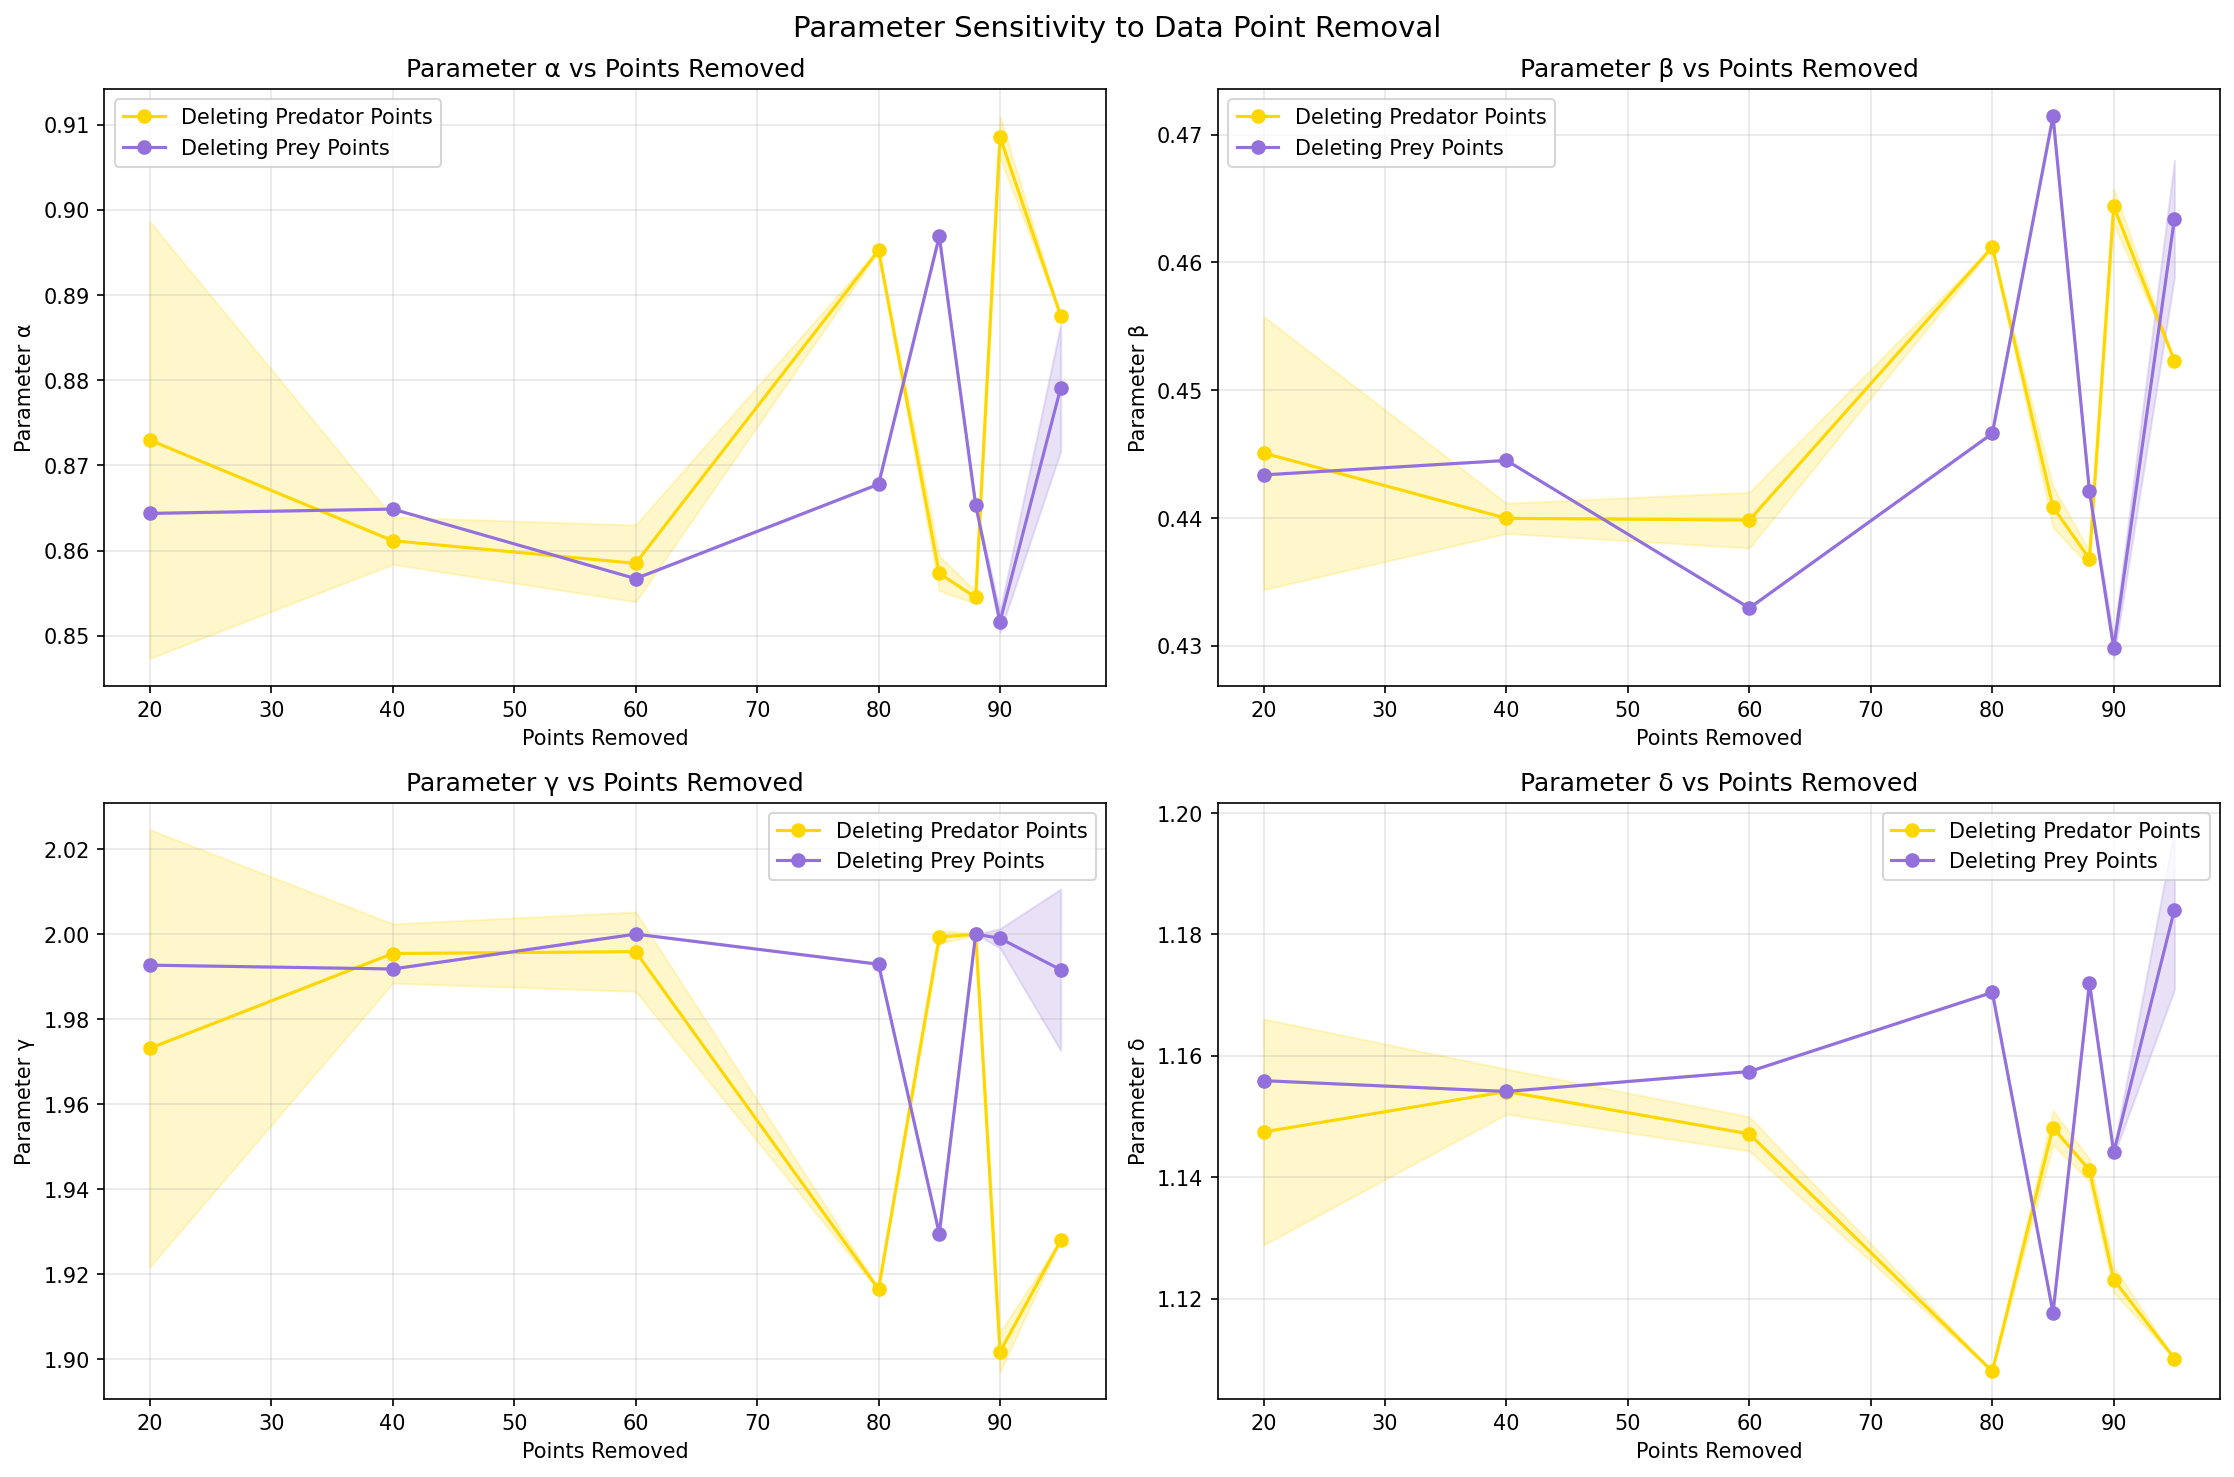

In [11]:
num_deletions = [20, 40, 60, 80, 85, 88, 90, 95]

# Run analyses
mean_params_Y, conf_params_Y, df_Y = optimization_with_deletion(
    t_obs, x_obs, y_obs,
    init_cond,
    num_deletions,
    bounds,
    fix_prey=True
)

mean_params_X, conf_params_X, df_X = optimization_with_deletion(
    t_obs, x_obs, y_obs,
    init_cond,
    num_deletions,
    bounds,
    fix_prey=False
)

# Create results dictionary
results = {
    'prey_fixed': {'means': mean_params_Y, 'confs': conf_params_Y},
    'pred_fixed': {'means': mean_params_X, 'confs': conf_params_X},
    'num_deletions': num_deletions
}

# Plot results
plot_statistical_results(results)

In [12]:
# First create the dataframes with the results
predator_deletion = pd.DataFrame({
    'points_removed': num_deletions,
    'alpha_mean': mean_params_Y[:, 0],
    'alpha_conf': conf_params_Y[:, 0],
    'beta_mean': mean_params_Y[:, 1],
    'beta_conf': conf_params_Y[:, 1],
    'gamma_mean': mean_params_Y[:, 2],
    'gamma_conf': conf_params_Y[:, 2],
    'delta_mean': mean_params_Y[:, 3],
    'delta_conf': conf_params_Y[:, 3]
})

prey_deletion = pd.DataFrame({
    'points_removed': num_deletions,
    'alpha_mean': mean_params_X[:, 0],
    'alpha_conf': conf_params_X[:, 0],
    'beta_mean': mean_params_X[:, 1],
    'beta_conf': conf_params_X[:, 1],
    'gamma_mean': mean_params_X[:, 2],
    'gamma_conf': conf_params_X[:, 2],
    'delta_mean': mean_params_X[:, 3],
    'delta_conf': conf_params_X[:, 3]
})

# Then create the results dictionary
results = {
    'predator_deletion': predator_deletion,
    'prey_deletion': prey_deletion
}

Baseline parameters:
α: 0.8599 ± 0.0000
β: 0.4397 ± 0.0000
γ: 2.0000 ± 0.0000
δ: 1.1581 ± 0.0000


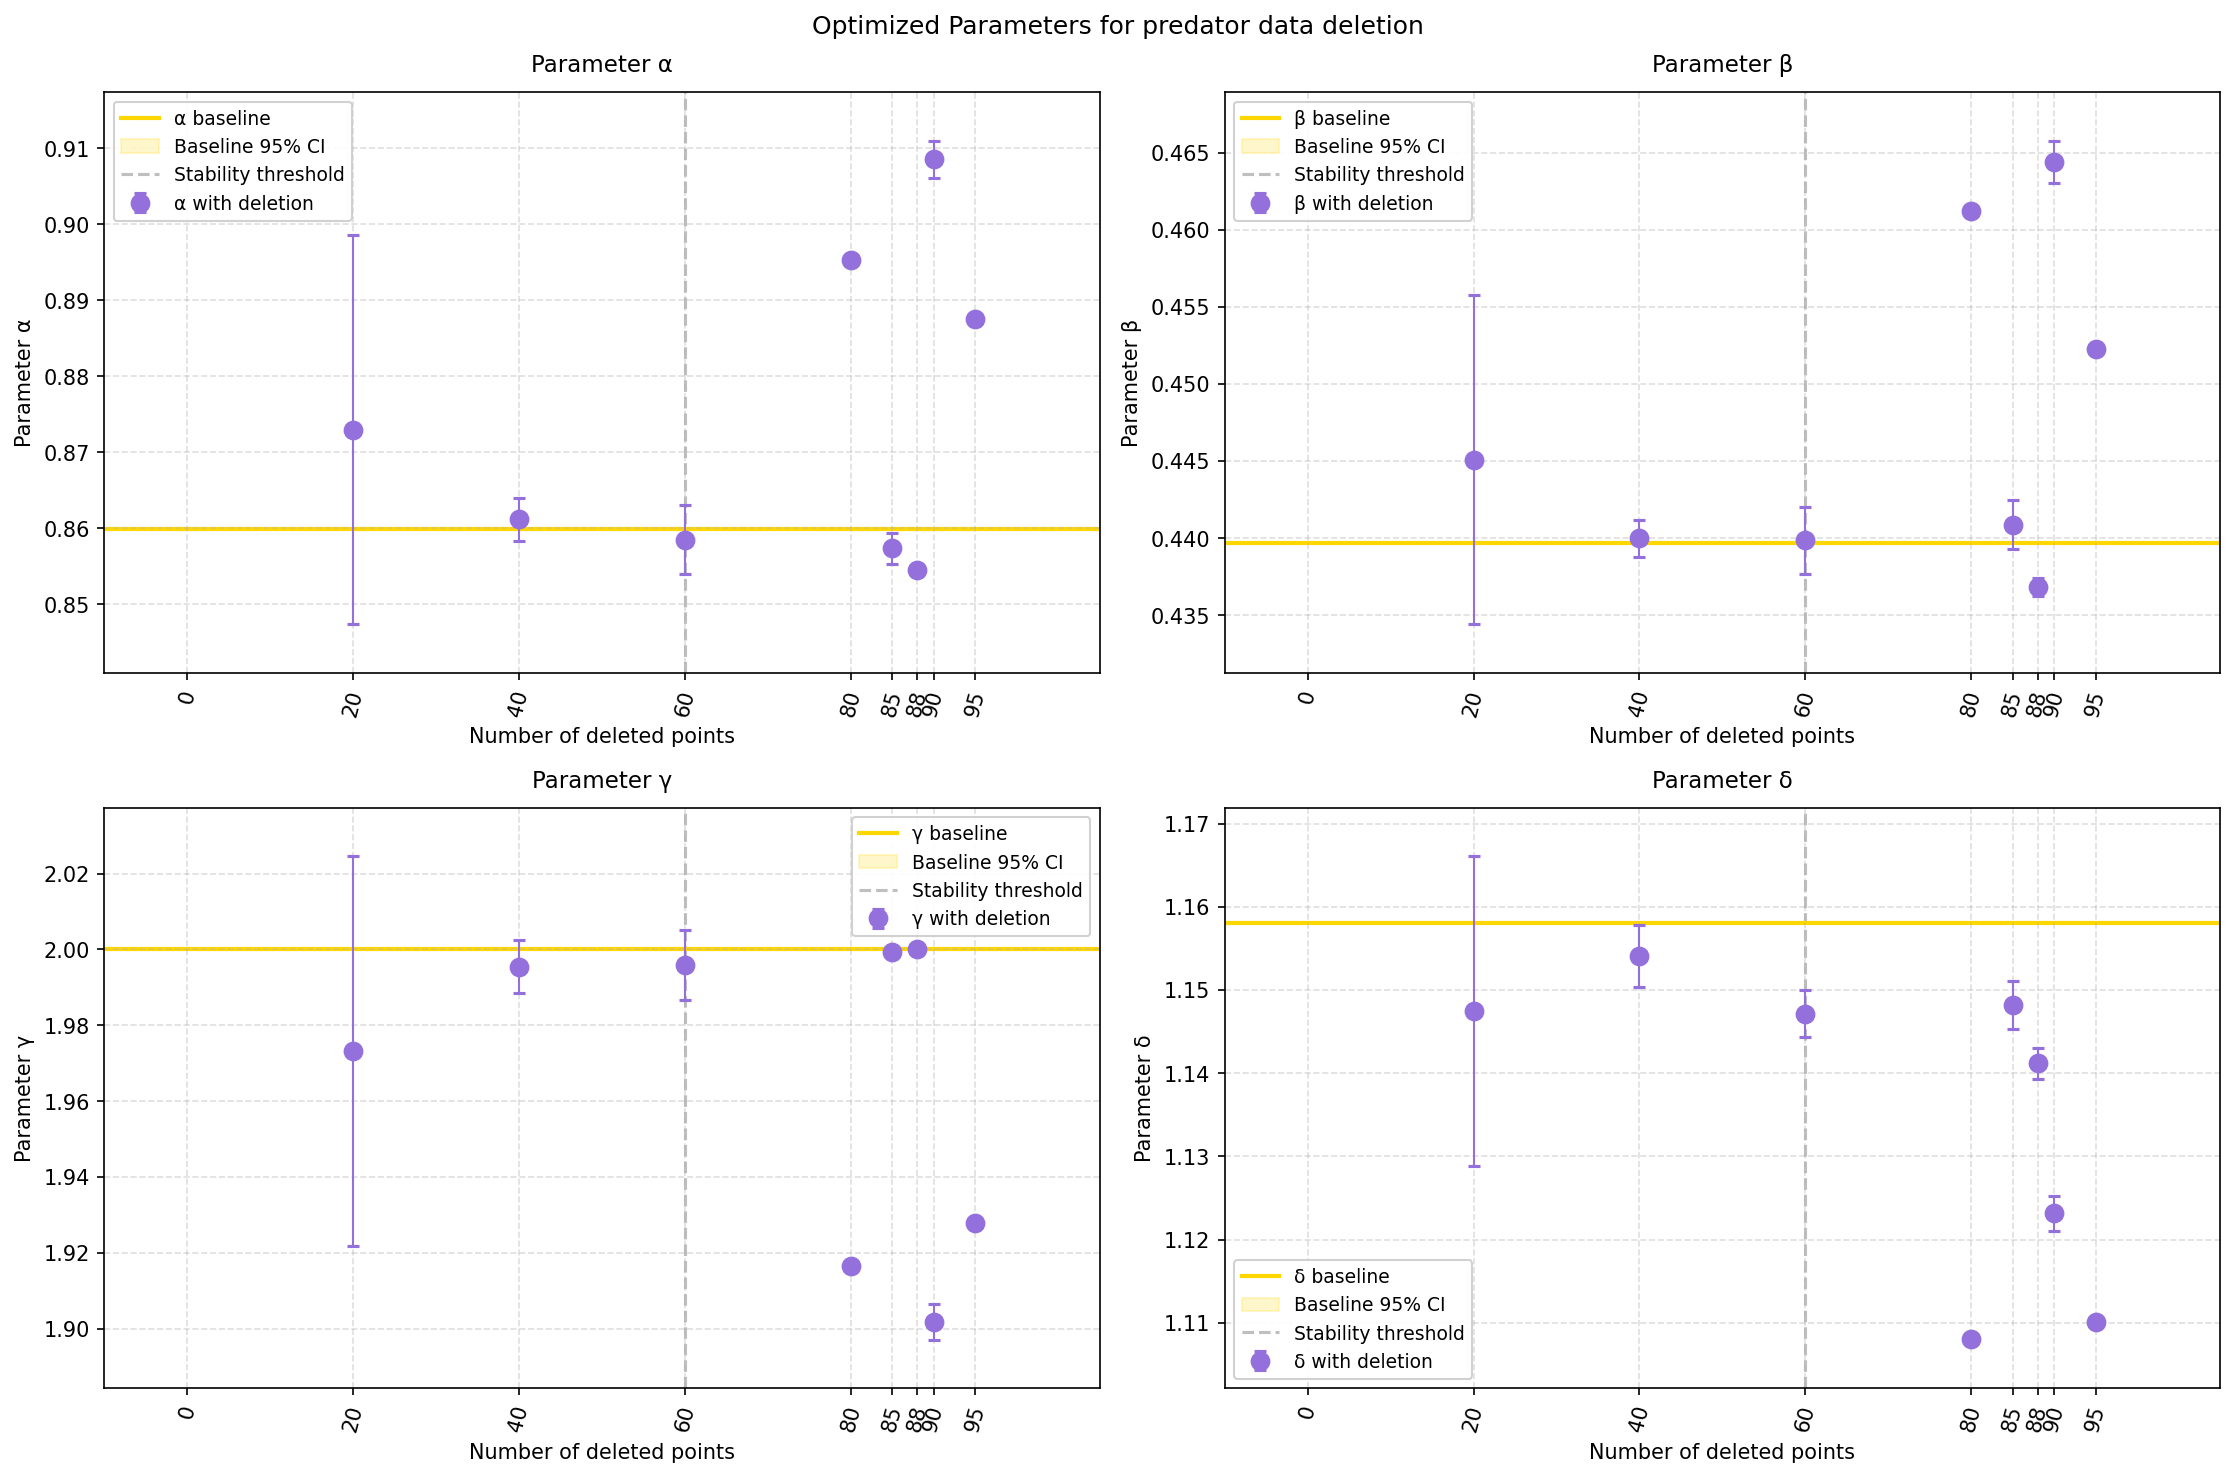

Baseline parameters:
α: 0.8599 ± 0.0000
β: 0.4397 ± 0.0000
γ: 2.0000 ± 0.0000
δ: 1.1581 ± 0.0000


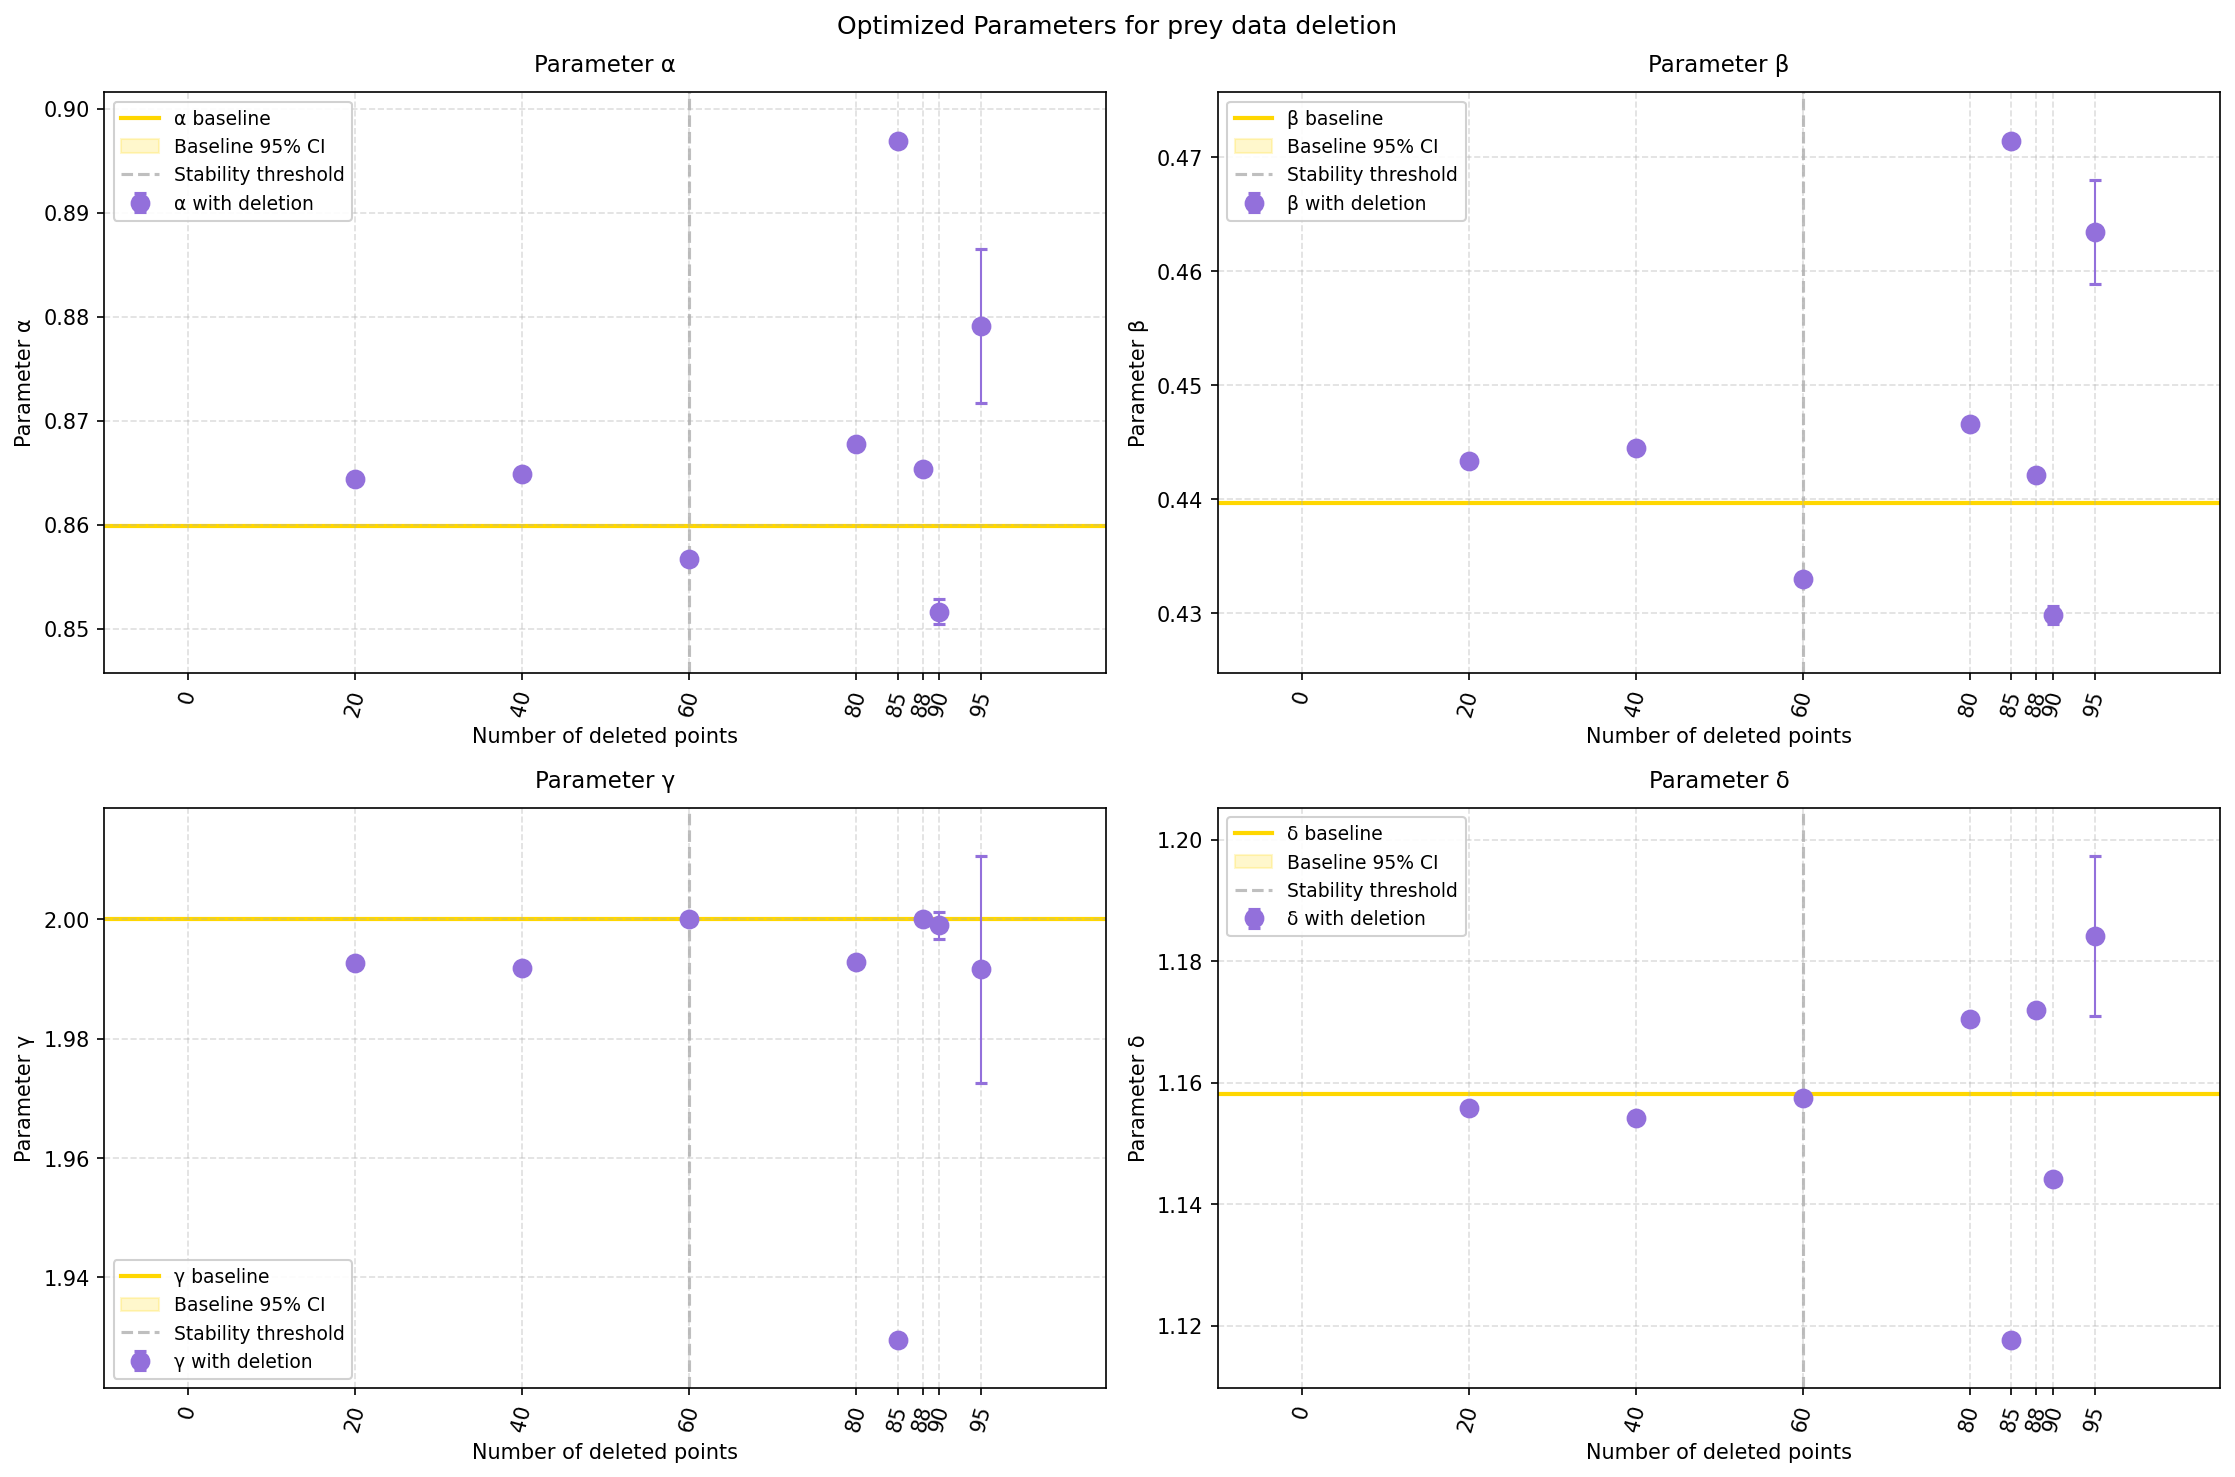

In [22]:
# Plot results
plot_deletion_results(num_deletions, mean_params_Y, conf_params_Y, 
                     baseline_params=baseline_params, 
                     baseline_conf=baseline_conf, 
                     deletion_type='predator')

plot_deletion_results(num_deletions, mean_params_X, conf_params_X, 
                     baseline_params=baseline_params, 
                     baseline_conf=baseline_conf, 
                     deletion_type='prey')

Now let's combine the two reduced time-series and see if we can still infer the parameters.



Starting combined deletion analysis...

Scenario 1/8: Removing 20 points from each time series...
Points remaining: 63


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   28.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   29.4s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.8643 ± 0.0000
- β: 0.4420 ± 0.0000
- γ: 1.9929 ± 0.0000
- δ: 1.1587 ± 0.0000

Scenario 2/8: Removing 40 points from each time series...
Points remaining: 38


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   34.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   34.9s remaining:   34.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   35.1s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.8638 ± 0.0022
- β: 0.4420 ± 0.0012
- γ: 1.9965 ± 0.0057
- δ: 1.1619 ± 0.0035

Scenario 3/8: Removing 60 points from each time series...
Points remaining: 12


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   28.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   29.0s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.8741 ± 0.0001
- β: 0.4439 ± 0.0000
- γ: 1.9497 ± 0.0001
- δ: 1.1189 ± 0.0001

Scenario 4/8: Removing 80 points from each time series...
Points remaining: 5


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   27.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   27.8s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   28.2s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.8599 ± 0.0057
- β: 0.4449 ± 0.0018
- γ: 1.9937 ± 0.0143
- δ: 1.1408 ± 0.0063

Scenario 5/8: Removing 85 points from each time series...
Points remaining: 4


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   22.6s remaining:   53.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   23.0s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   23.5s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.8463 ± 0.0000
- β: 0.4452 ± 0.0000
- γ: 2.0000 ± 0.0000
- δ: 1.0872 ± 0.0000

Scenario 6/8: Removing 88 points from each time series...
Points remaining: 1


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.9235 ± 0.5178
- β: 0.8615 ± 0.4553
- γ: 0.9245 ± 0.4323
- δ: 0.5759 ± 0.3597

Scenario 7/8: Removing 90 points from each time series...
Points remaining: 1


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Optimized parameters:
- α: 0.7956 ± 0.4390
- β: 0.7460 ± 0.4493
- γ: 0.8011 ± 0.3284
- δ: 1.1711 ± 0.4826

Scenario 8/8: Removing 95 points from each time series...
Points remaining: 1


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished



Optimized parameters:
- α: 0.7431 ± 0.4403
- β: 1.0748 ± 0.4154
- γ: 0.9371 ± 0.4784
- δ: 1.0610 ± 0.4288
Baseline parameters:
α: 0.8599 ± 0.0000
β: 0.4397 ± 0.0000
γ: 2.0000 ± 0.0000
δ: 1.1581 ± 0.0000


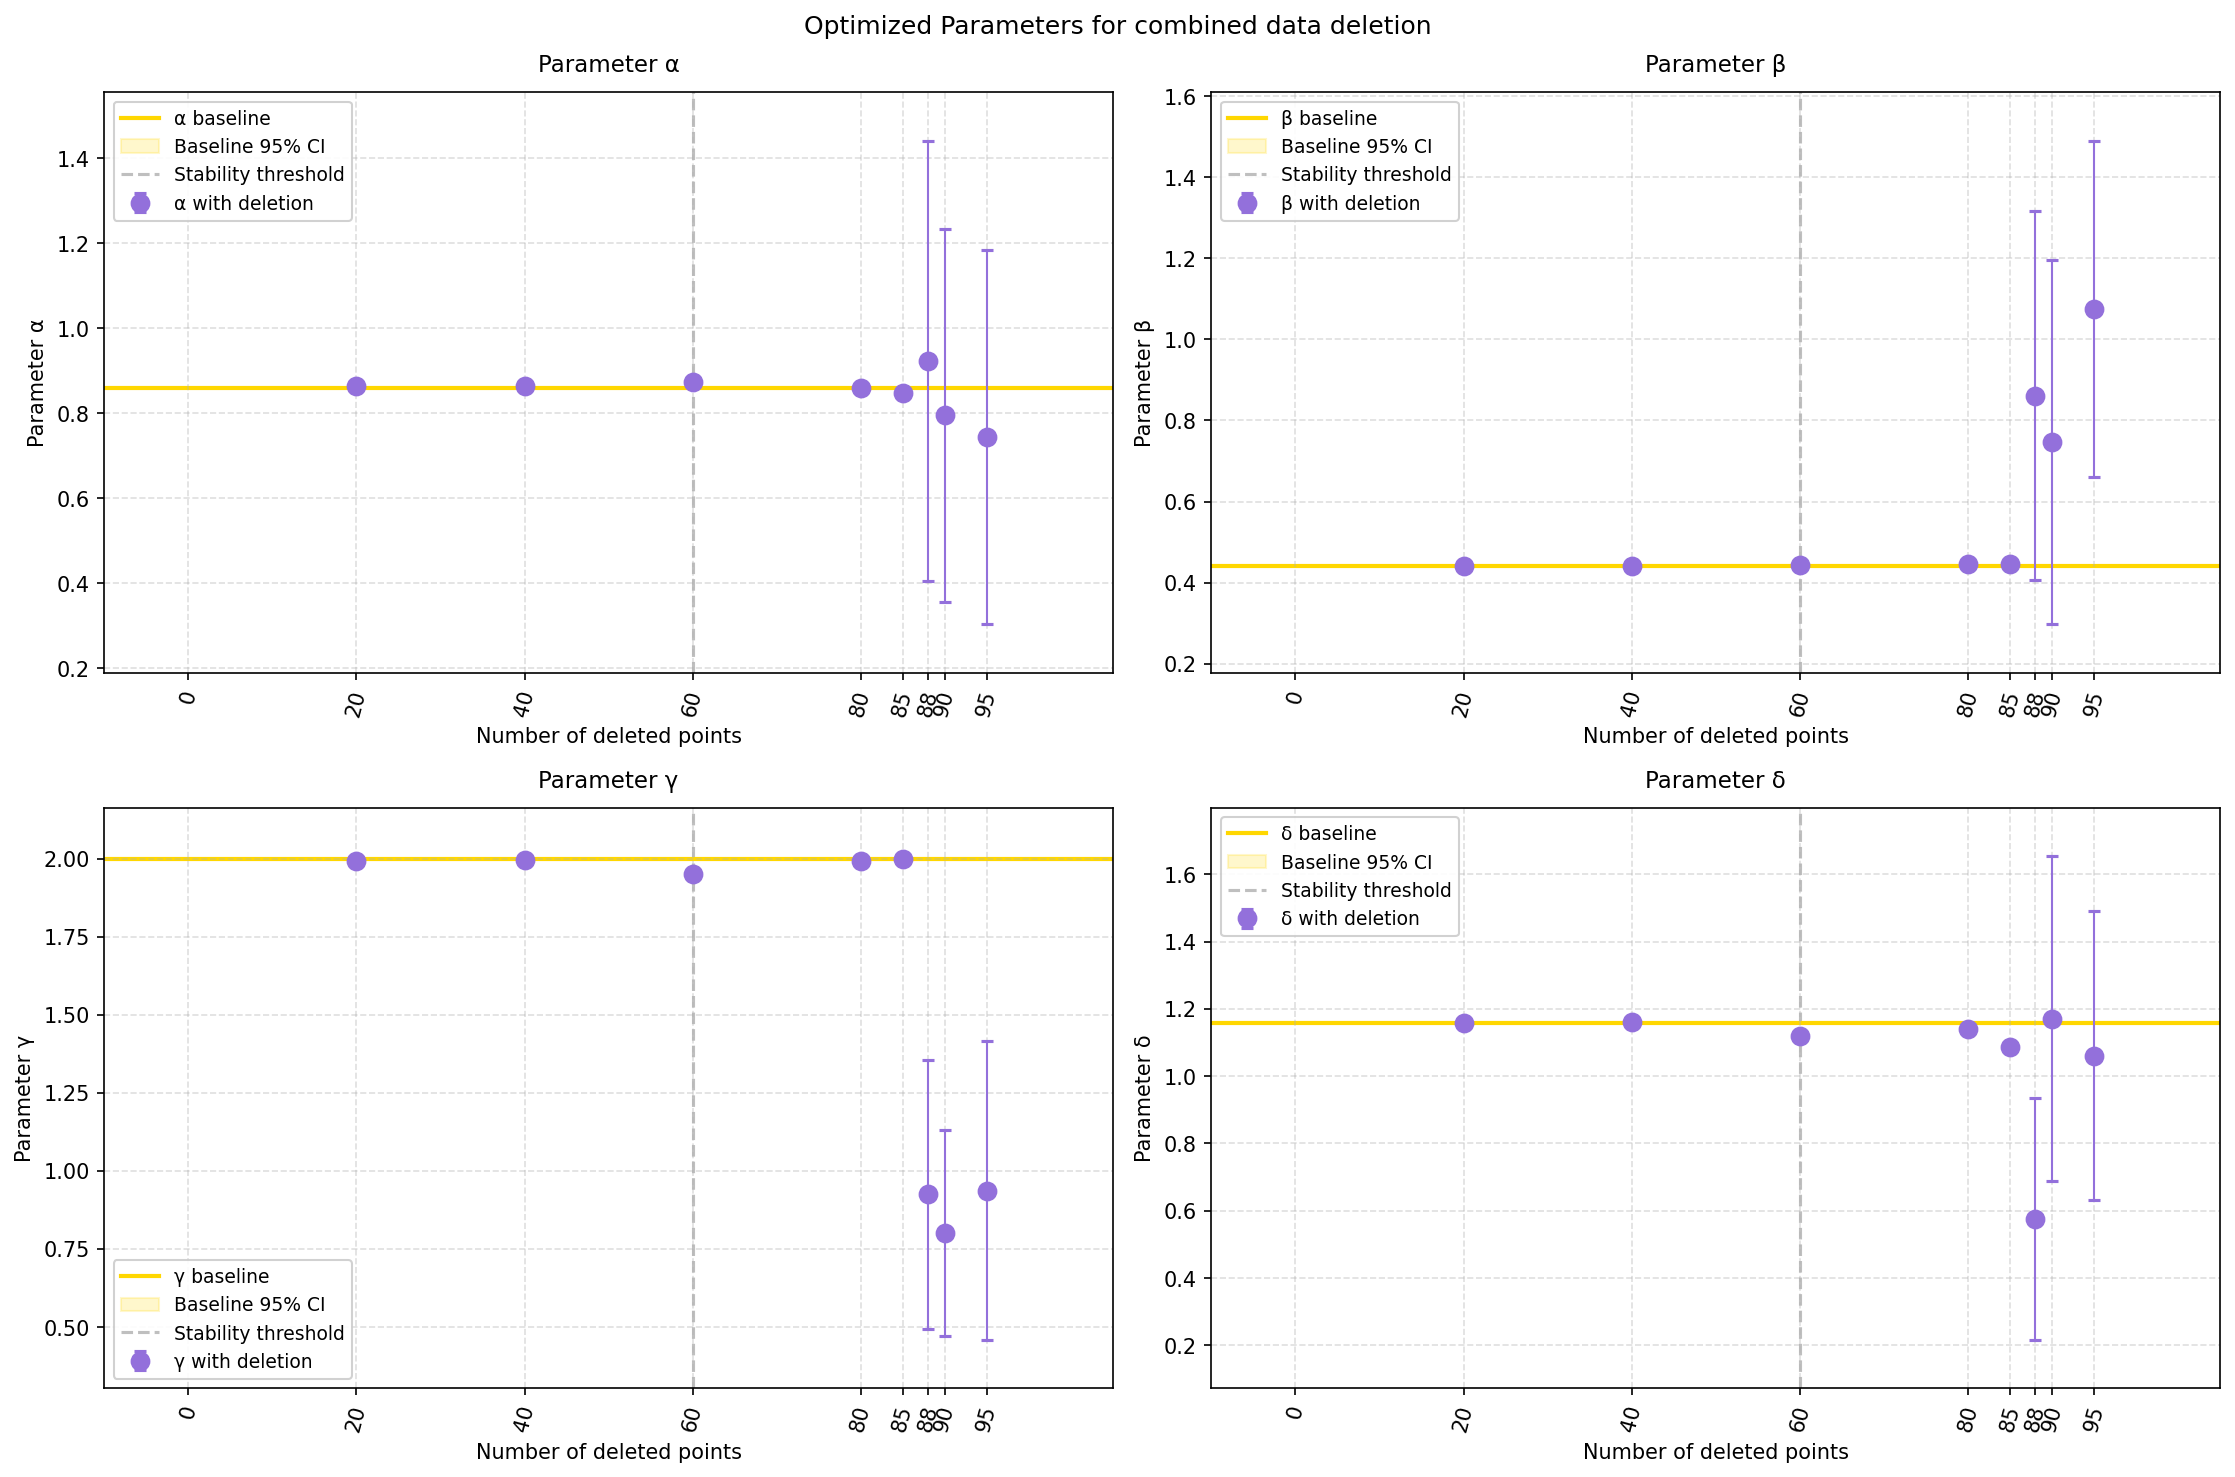

In [14]:
def optimization_with_combined_deletion(t_data: np.ndarray, X_data: np.ndarray, Y_data: np.ndarray,
                                      init_cond: List[float], num_deletions: List[int], 
                                      bounds: List[Tuple[float, float]], n_trials: int = 10):
    """
    Calculate optimal parameters when deleting points from both time series
    """
    mean_params = np.zeros((len(num_deletions), 4))
    conf_params = np.zeros((len(num_deletions), 4))
    
    print("\nStarting combined deletion analysis...")
    
    for i, deletions in enumerate(num_deletions):
        print(f"\nScenario {i+1}/{len(num_deletions)}: Removing {deletions} points from each time series...")
        
        # Generate different deletion indices for each time series
        np.random.seed(i * 100)  # Seed for prey deletions
        prey_delete_indices = np.random.choice(range(1, len(X_data)), size=deletions, replace=False)
        
        np.random.seed(i * 100 + 50)  # Different seed for predator deletions
        pred_delete_indices = np.random.choice(range(1, len(Y_data)), size=deletions, replace=False)
        
        # Create masks
        prey_mask = np.ones(len(t_data), dtype=bool)
        pred_mask = np.ones(len(t_data), dtype=bool)
        prey_mask[prey_delete_indices] = False
        pred_mask[pred_delete_indices] = False
        
        # Combined mask (keep points present in both series)
        combined_mask = prey_mask & pred_mask
        
        # Create reduced datasets
        t_reduced = t_data[combined_mask]
        X_reduced = X_data[combined_mask]
        Y_reduced = Y_data[combined_mask]
        
        print(f"Points remaining: {np.sum(combined_mask)}")
            
        # Run parallel optimizations
        deletion_params = Parallel(n_jobs=-1, verbose=10)(
            delayed(run_single_trial)(
                (i * 100) + seed,
                t_reduced,
                X_reduced,
                Y_reduced,
                init_cond,
                bounds
            ) for seed in range(n_trials)
        )
        
        # Calculate statistics
        deletion_params = np.array(deletion_params)
        means, confs = calc_mean_conf(deletion_params)
        
        mean_params[i, :] = means
        conf_params[i, :] = confs
        
        print(f"\nOptimized parameters:")
        param_names = ['α', 'β', 'γ', 'δ']
        for j, param in enumerate(param_names):
            print(f"- {param}: {means[j]:.4f} ± {confs[j]:.4f}")
    
    return mean_params, conf_params

# Use fewer deletion points since we're removing from both series
# Run the combined analysis
mean_params_combined, conf_params_combined = optimization_with_combined_deletion(
    t_obs, x_obs, y_obs,
    init_cond,
    num_deletions,
    bounds
)

# Plot results
plot_deletion_results(num_deletions, mean_params_combined, conf_params_combined, 
                     baseline_params=baseline_params, 
                     baseline_conf=baseline_conf, 
                     deletion_type='combined')

Now we see that we can remove around 88-95 points from each dataset and successfully estimate the optimal parameters. Let's investigate which are our critical points. 

In [15]:
optimized_params = optimize_lotka_volterra(t_obs, x_obs, y_obs, init_guess)
sensitivities, data_point_sensitivities = sensitivity_analysis(t_obs, x_obs, y_obs, optimized_params)

c:\Users\magggien\Documents\Masters\LotkaVolterra-ModelFitting\src\model.py:106: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  model_result = odeint(lotka_volterra, [x0, y0], t_data, args=(alpha, beta, gamma, delta))


In [17]:
critical_points = identify_critical_data_points(data_point_sensitivities)
print("Critical data points:", critical_points)

Critical data points: [ 3  4  5  6  7  8  9 10 14 15 19 20 21 22 23 24 25 27 28 29 32 39 41 48
 50 52 53 55 56 57 58 59 60 61 65 71 72 73 74 75 76 77 84 85 86 93 94 97
 98 99]


In [18]:
top_n = 5
top_indices = data_point_sensitivities.argsort()[-top_n:][::-1]
print(f"Top {top_n} critical data points with most influence on the parameters: {top_indices}")

Top 5 critical data points with most influence on the parameters: [ 7  6 72 93 39]


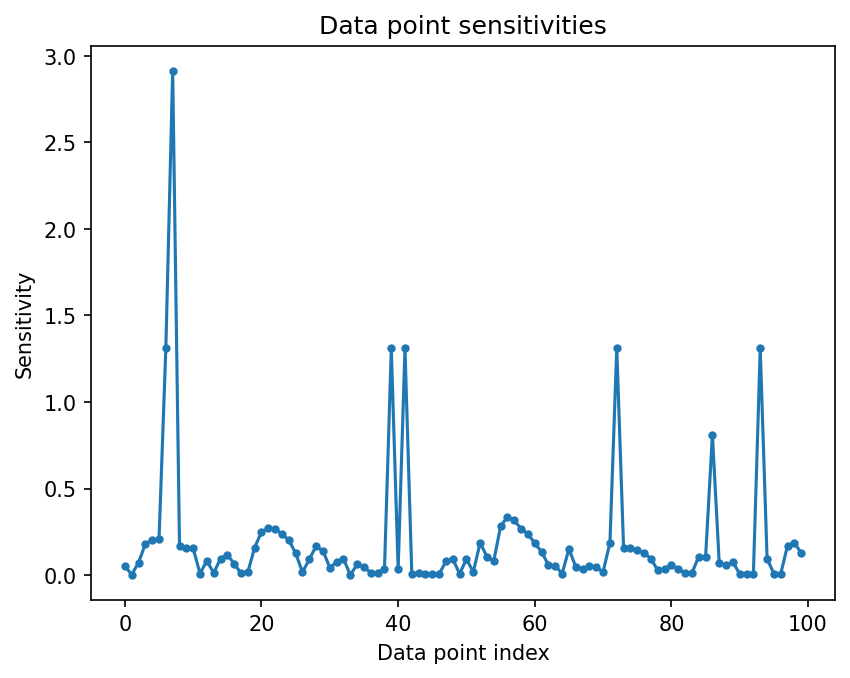

In [19]:
plt.figure()
plt.plot(data_point_sensitivities, '.-')
plt.xlabel("Data point index")
plt.ylabel("Sensitivity")
plt.title("Data point sensitivities")
plt.show()

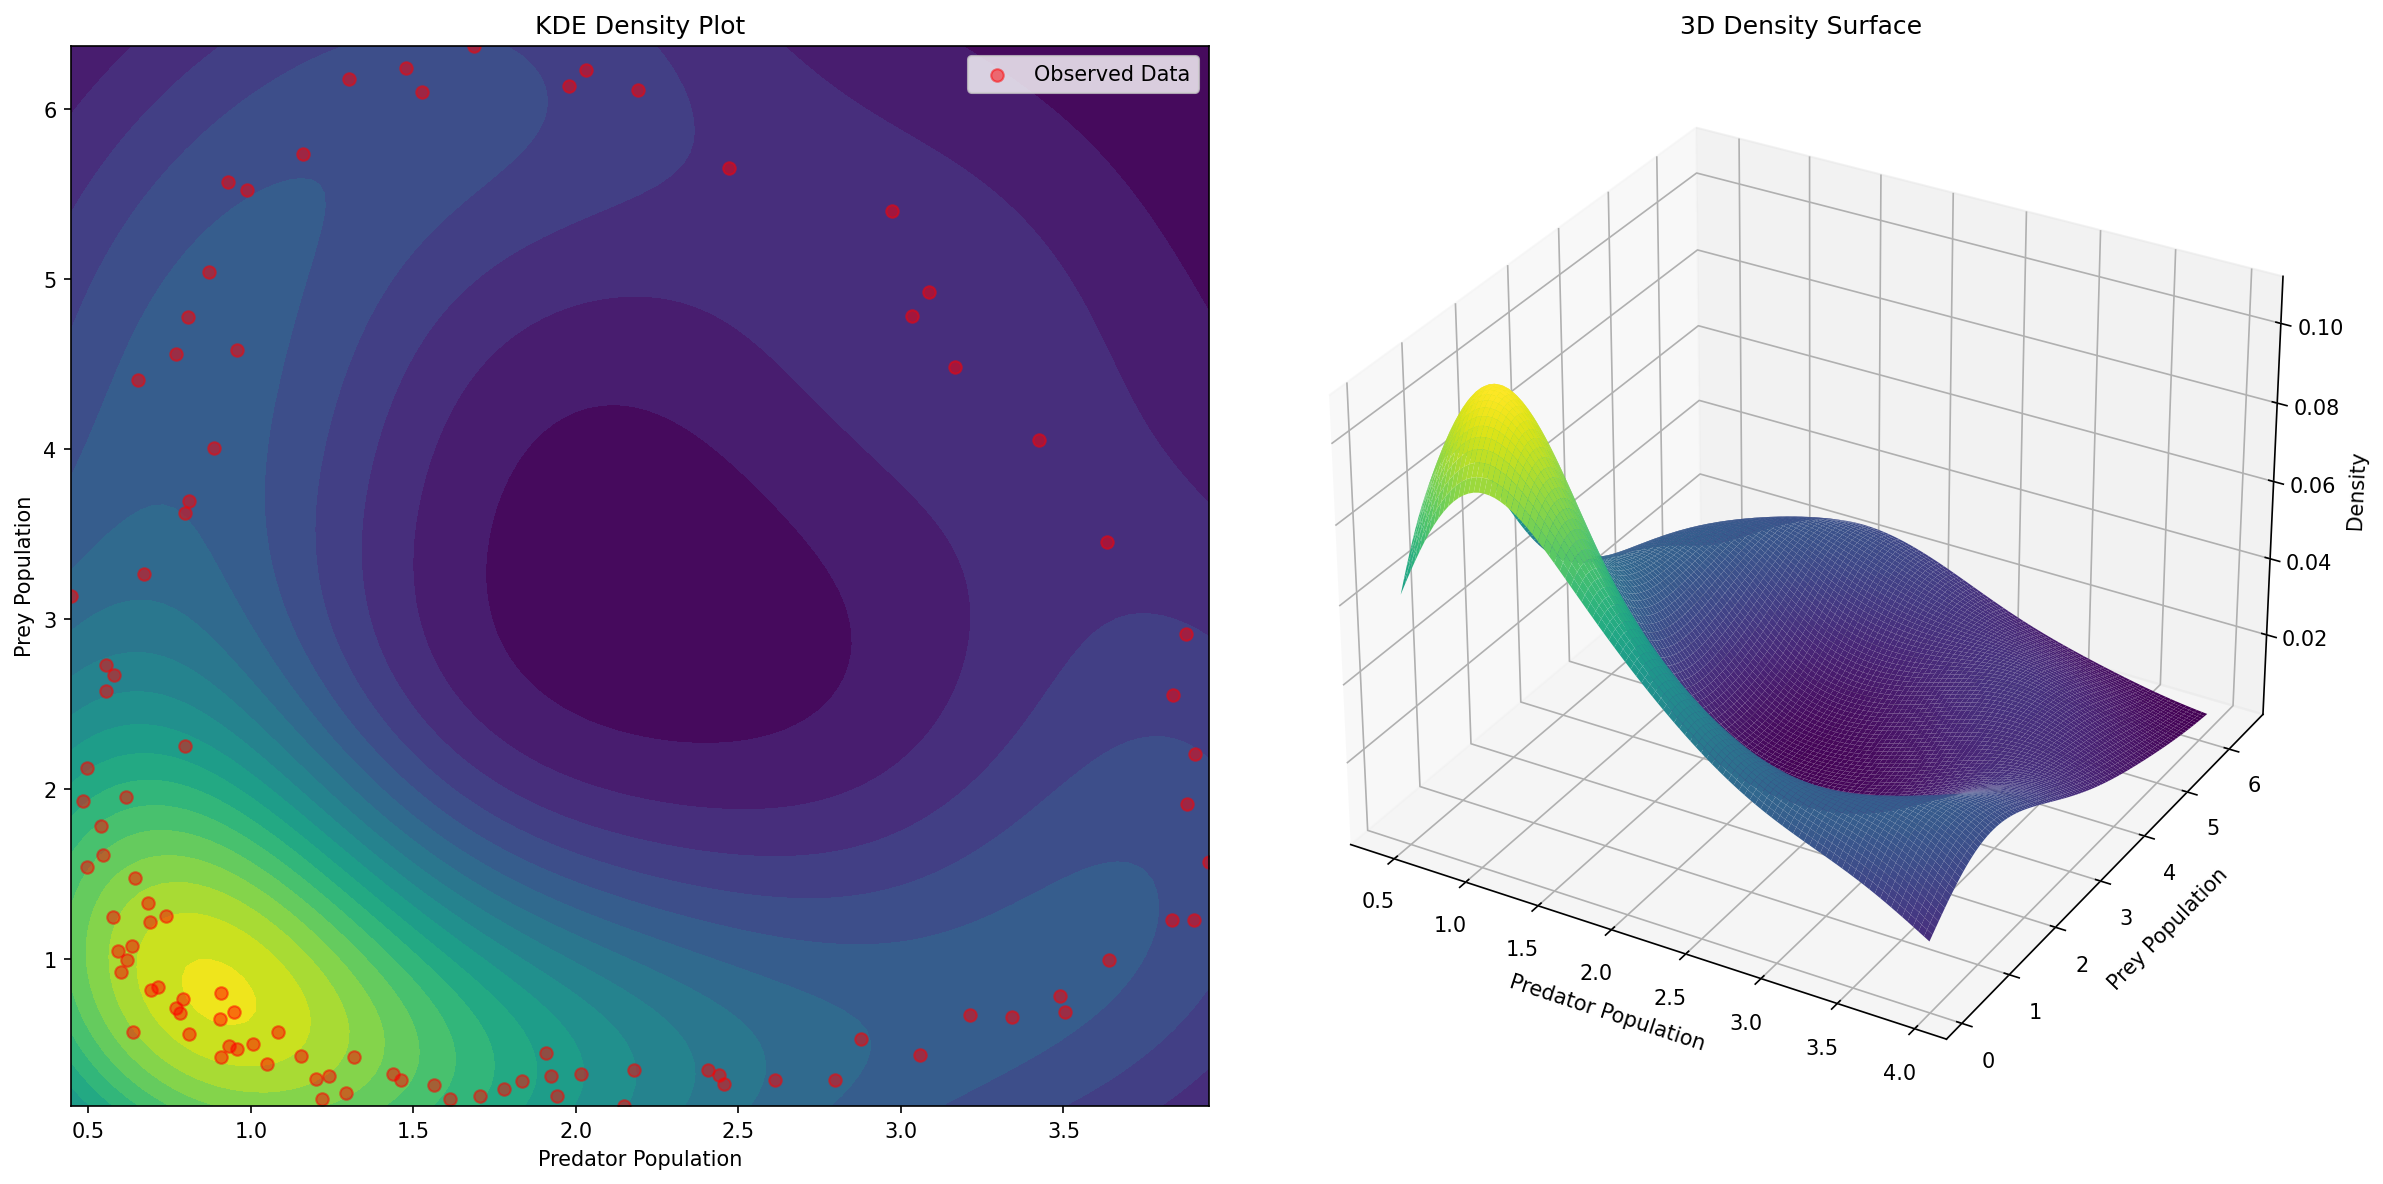

In [20]:
visualize_predator_prey_data(t_obs, x_obs, y_obs)